# Harmonic signal spectrum

## The purpose of work

It is necessary to obtain graphs of a square signal (single polar meander) with frequencies of 1,2,4,8 hertz and the spectra of these signals.

## Imports of necessary libraries

In [1]:
%matplotlib notebook
from numpy import sin, cos, linspace, cumsum
#from numpy.add import accumulate
from scipy.fft import rfft, rfftfreq, irfft, fft
from scipy.signal import square
from math import *
import matplotlib.pyplot as plt

## Core functions

In [56]:
# Static global variables to work with the signa
TIME_RANGE = 4  # Time range (sec)
FS         = 2048 # Sampling freq (Hz)


def t_step(w):
    """
    Generates a time steps array
    """
    N         = FS * TIME_RANGE
    TIME_STEP = 1 / FS # Sample time interval
    return linspace(0, TIME_RANGE, N)


def f_step(w):
    """
    Generates a frequency steps array
    """
    N         = FS * TIME_RANGE
    FREQ_STEP = FS / N # Sample freq interval
    return linspace(0, TIME_RANGE, N)


def signal(_func_):
    """
    Decorator function for restoring signal from mathematical function
    """
    def wrapper(A, k, t, w, q):
        t      = t_step(w)
        f      = [_func_(A, k, ti, w, q) for ti in t]
        return (t, f) 
    return wrapper


def spectrum(__func__):
    """
    Function realizing spectrum of signal
    """
    
    N = FS * TIME_RANGE
    
    freq = rfftfreq(N, 1 / FS)
    ampl = rfft(__func__)
     
    ampl = normalize(ampl) # Normalize complex spectrum
    return freq, ampl


def normalize(fft):
    """
    Function realizing normalizing of fft spectrum
    """
    return abs(fft) / TIME_RANGE / (FS / 2)


def modulation(harmonic, meander, type='ampl'):
    a = 1     # Амплитуда сигнала
    w = 16    # Несущая частота сигнала
    T = 1 / w # Период сигнала
    harms = len(harmonic[0])
    mends = len(meander[0])
    if harms != mends:
        raise ValueError(f'Dimensions and sizes of two signal arrays must be equal! Actual sizes: [{harms}], [{mends}]')
    
    def freq(harmonic, meander):
        f = []
        
        '''
        for i in range(harms):
            if meander[1][i] == 1: continue
            f.append(harmonic[1][i])
        '''
        i = 0
        while i < harms:
            f.append(harmonic[1][i])
            if meander[1][i - 1] == 1:
                i += 2
            else: i += 1
                
        t = harmonic[0][:len(f):]
        print(len(t), len(f))
        return (t, f)

    modulate = {
        'ampl'  : [harmonic[0], [meander[1][i] * harmonic[1][i] for i in range(harms)]],
        'freq'  : freq(harmonic, meander),
        'phase' : [harmonic[0], [((meander[1][i] if meander[1][i] == 1 else -1) * harmonic[1][i]) for i in range(harms)]]
    }
    
    return modulate[type]


def restore_decay(x, A, k, a=0):
    """
    Additive fade-restore function
    """
    y = [dump(xi, A, k) + a for xi in x]
    return (y, [-yi for yi in y])


def dump(t, A, k=0):
    """
    Additive function to compute dumping function amplitude
    """
    return A * exp(-k * t)



## Additive functions for plotting image

In [57]:
def ylabel(axes, label):
    """
    Method for setting y label to subplots
    """
    for axis in axes:
        axis.set_ylabel(label)

        
def xlabel(axes, label):
    """
    Method for setting x label to subplots
    """
    for axis in axes:
        axis.set_xlabel(label)
        
        
def grid(axes):
    """
    Method for drawing grid on subplots
    """
    for axis in axes:
        axis.grid()
        
        
def xlim(axes, lim):
    """
    Method for setting the x bounds of the displayed function on subplots
    """
    if len(lim) == 1:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[0])
    else:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[i])

            
def ylim(axes, lim):
    """
    Method for setting the y bounds of the displayed function on subplots
    """
    if len(lim) == 1:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[0])
    else:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[i])
        
        
def display(fig, x, y, color='gray'):
    """
    Additive method for plotting custom signals
    """
    weight = 1
    if color == 'gray':
        style = 'dashed'
    else:
        style = 'solid'
        
    fig.plot(x, y, color, lw=weight, ls=style)
    fig.grid()

## Describing mathematical functions

In [58]:
A = 1.0
k = 0.0


@signal
def harmonic(A, k, t, w, q):
    """
    Function-wrapper for mathematical function
    """
    w *= 2*pi
    return dump(t, A, k) * sin(w * t + q)
    # dump(t, A, k) * (sin(1*w*t) / 1 + sin(3*w*t) / 3 + sin(5*w*t) / 5 + sin(7*w*t) / 7 + sin(9*w*t) / 9)
    # dump(t, A, k) * sin(1*w*t)
    
    
@signal
def meander(A, k, t, w, q):
    w *= 2 * pi
    sqr = square(w * t)
    return dump(t, A, k) * sqr if sqr >= 0 else 0


def freq_modulation(A1, k1, w1, q1, A2, k2, w2, q2): 
    w1  = 2 * pi
    w2  = 2 * pi
    t   = t_step(w1)
    f   = [dump(ti, A1, k1) * cos((2 * w1 if square(w2 * ti + q2) == A2 else w1) * ti) for ti in t]  
    return (t, f)

## Computing

In [61]:
# Computing and modulating signals
xma, yma = modulation(harmonic(A, k, None, 16, 0), meander(A, k, None, 2, 0), 'ampl')
xmf, ymf = modulation(harmonic(A, k, None, 4, 0), meander(A, k, None, 2, 0), 'freq')
xmp, ymp = modulation(harmonic(A, k, None, 10, 0), meander(A, k, None, 2, 0), 'phase')

# Computing spectrums
xsa, ysa = spectrum(yma)
xsf, ysf = spectrum(ymf)
xsp, ysp = spectrum(ymp)

6143 6143
6143 6143
6143 6143


## Plotting

<IPython.core.display.Javascript object>


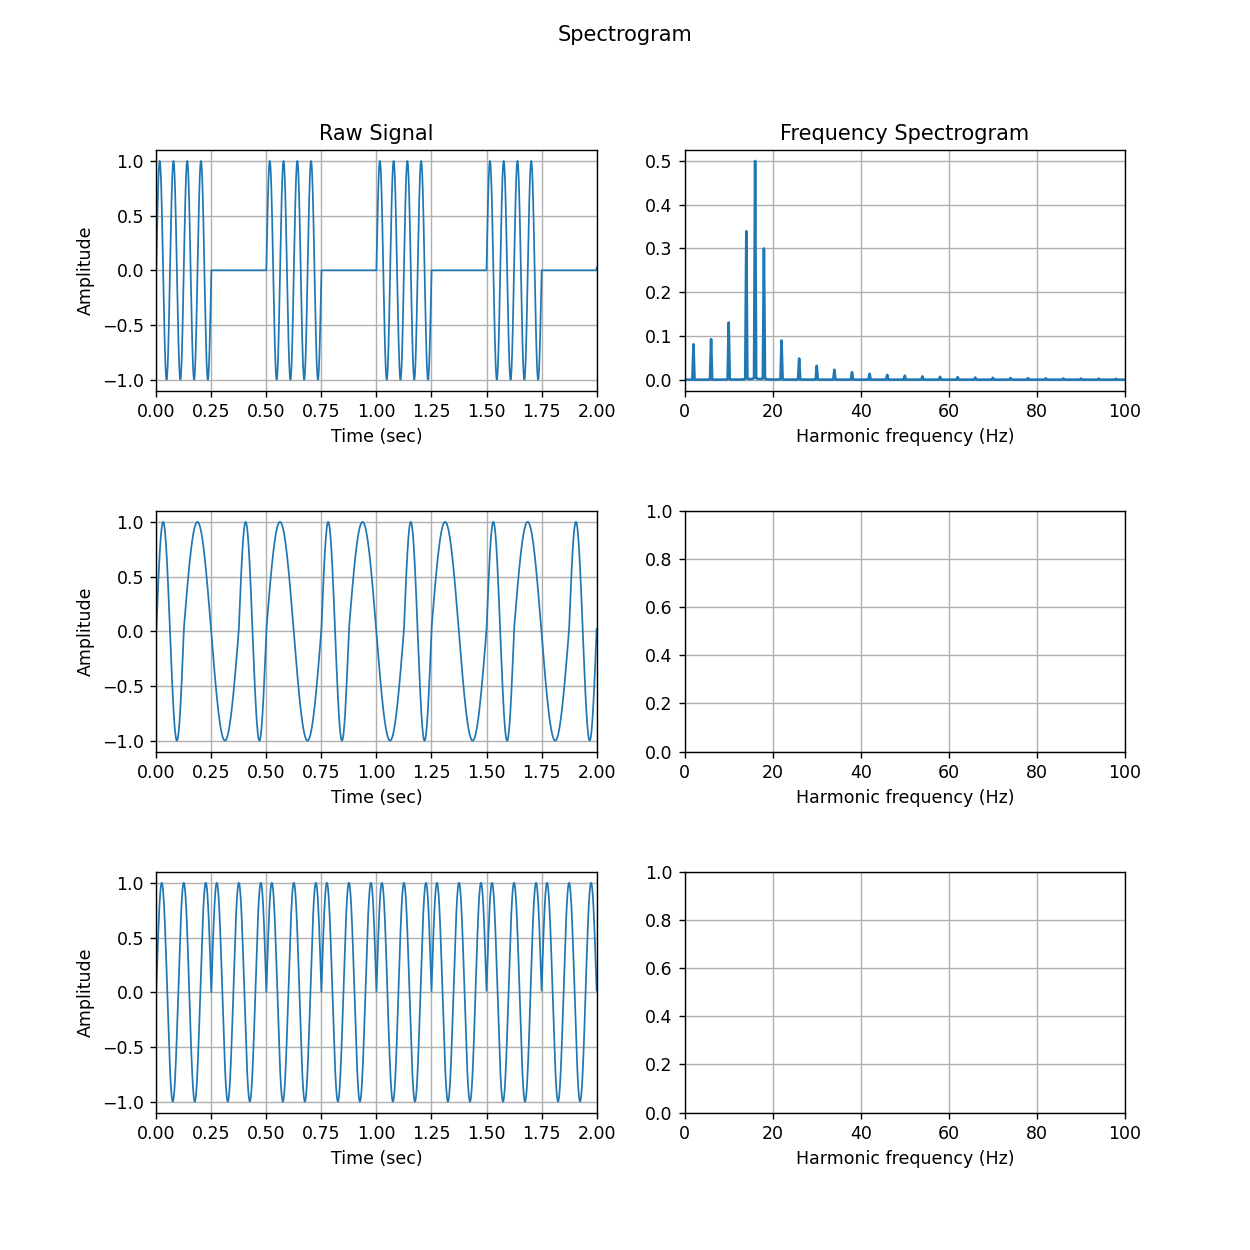

ValueError: x and y must have same first dimension, but have shapes (4097,) and (3072,)

In [62]:
# Creation of figure and subplots
fig, ((afunc1, aspec1), (afunc2, aspec2), (afunc4, aspec4)) = plt.subplots(figsize=(10, 10), dpi=100, nrows=3, ncols=2)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Spectrogram')
signals   = fig.axes[::2]
spectrums = fig.axes[1::2]

# Setting visible intervals
xlim(signals, [(0, 2)])
xlim(spectrums, [(0, 100)])

# Drawing grid
grid(signals)
grid(spectrums)

# Setting y labels
ylabel(signals, 'Amplitude')

# Setting x labels
xlabel(signals, 'Time (sec)')
xlabel(spectrums, 'Harmonic frequency (Hz)')

# Setting column titles
afunc1.set_title('Raw Signal')
aspec1.set_title('Frequency Spectrogram')

style = '-'

# Plotting
afunc1.plot(xma, yma, style, lw=1)
afunc2.plot(xmf, ymf, style, lw=1)
afunc4.plot(xmp, ymp, style, lw=1)

aspec1.plot(xsa, ysa, style)
aspec2.plot(xsf, ysf, style)
aspec4.plot(xsp, ysp, style)

In [ ]:
def runOp(op, val):
    return op(val)

# declare full function
def add(x, y):
    return x+y

# run example
def main():
    result = runOp(lambda y: add(3, y), 2) # is 4
    print(result)

main()

In [ ]:
def mod(a):
    print(a())
    
def har(k, l):
    return k()
    
def mdr(l):
    return l
    
mod(har(5, mdr(2)))

callable(har)